google-play-scraper 설치를 한다.

In [1]:
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google_play_scraper import Sort, reviews_all
raw_data = reviews_all(
    'com.ryanair.cheapflights', 
    # 'com.ryanair.cheapflights',
    lang='en',
    country='us',
    sort=Sort.MOST_RELEVANT
)

In [3]:
from pprint import pprint
pprint(raw_data[:5])

[{'at': datetime.datetime(2019, 12, 8, 12, 46, 39),
  'content': 'Cheap flights, but you get what you pay for. Check in through '
             'the app has to be done 24hrs in advance (the app frequently '
             'crashes when trying to do this), or they ask you to pay to check '
             'in when you get there. I also purchased parking through the app, '
             'but it does not provide a location for the service. The '
             'temperature in flight was very hot and uncomfortable even with '
             'the vents open...during the winter. Good enough for a short '
             "flight, but I wouldn't travel too far with Ryanair.",
  'repliedAt': None,
  'replyContent': None,
  'reviewCreatedVersion': '3.74.1',
  'reviewId': '90298674-f009-4499-beb0-b3488189d8fa',
  'score': 2,
  'thumbsUpCount': 40,
  'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g',
  'userName': 'A Google us

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import csv

data_li = [(info['content'], info['score'], info['thumbsUpCount'], info['at']) for info in raw_data]

with open("/content/drive/MyDrive/application_data.csv", 'wt', encoding='utf-8', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(["contents", "star", "agree", "date"])

        for data in data_li:
          
            csv_writer.writerow(data)

In [6]:
import pandas as pd

ryanair = pd.read_csv("/content/drive/MyDrive/application_data.csv")
ryanair

,contents,star,agree,date
0,"Cheap flights, but you get what you pay for. C...",2,40,2019-12-08 12:46:39
1,"Awful app tries to up sell you 4 ways, 4 times...",1,49,2021-10-12 21:45:50
2,"From the user's point of view, the application...",1,23,2023-04-01 08:11:18
3,Lately (last couple of months' already) app is...,2,15,2023-04-01 22:28:42
4,The app is excellent; well laid out and design...,5,6,2023-04-14 09:33:12
...,...,...,...,...
23602,Ok,5,0,2016-09-27 21:02:31
23603,Ok,4,0,2016-10-14 07:07:47
23604,NaN,1,0,2014-02-14 21:35:30
23605,NaN,1,0,2014-02-22 14:06:56


In [7]:
ryanair=ryanair[['star','contents']]
ryanair

,star,contents
0,2,"Cheap flights, but you get what you pay for. C..."
1,1,"Awful app tries to up sell you 4 ways, 4 times..."
2,1,"From the user's point of view, the application..."
3,2,Lately (last couple of months' already) app is...
4,5,The app is excellent; well laid out and design...
...,...,...
23602,5,Ok
23603,4,Ok
23604,1,NaN
23605,1,NaN


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import json
import sklearn

from sklearn.model_selection import train_test_split

In [9]:
ryanair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23607 entries, 0 to 23606
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   star      23607 non-null  int64 
 1   contents  23586 non-null  object
dtypes: int64(1), object(1)
memory usage: 369.0+ KB


<Axes: xlabel='star', ylabel='count'>

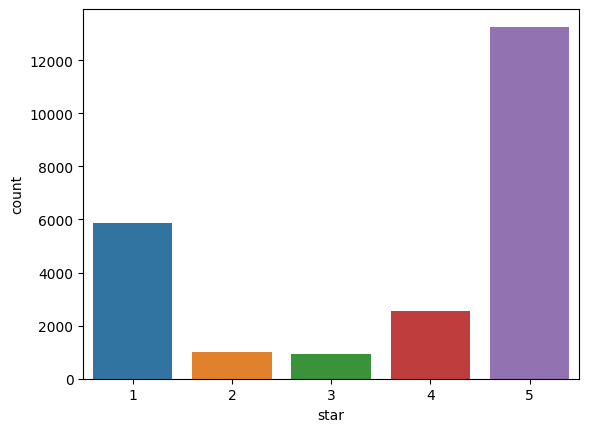

In [10]:
sns.countplot(x='star', data=ryanair)

별점을 이용한 긍정/부정 리뷰의 구분

In [11]:
#아마존 리뷰 데이터 참고
#1, 2점은 class 1로(negative), 4, 5점은 class 2로(positive). 3은 제거한다.
star3=ryanair[ryanair['star']==3].index
ryanair=ryanair.drop(star3)

# nan 값 제거
ryanair = ryanair.dropna()

ryanair.reset_index(drop=True, inplace=True)

ryanair

,star,contents
0,2,"Cheap flights, but you get what you pay for. C..."
1,1,"Awful app tries to up sell you 4 ways, 4 times..."
2,1,"From the user's point of view, the application..."
3,2,Lately (last couple of months' already) app is...
4,5,The app is excellent; well laid out and design...
...,...,...
22640,1,Απαράδεκτο
22641,1,La mia esperienza: prima di partire per le vac...
22642,1,😂😂😂😂😂😂😂😂😂😂😂
22643,5,Ok


In [12]:
ryanair=ryanair.reset_index() #중간에 빈 인덱스마다 땡기기 위해 리셋
ryanair=ryanair[['star','contents']] #새로 생긴 인덱스라는 열 제거
ryanair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22645 entries, 0 to 22644
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   star      22645 non-null  int64 
 1   contents  22645 non-null  object
dtypes: int64(1), object(1)
memory usage: 354.0+ KB


In [13]:
ryanair['class']=[1 if x==1 or x==2 else 2 for x in ryanair['star']]
ryanair #1점과 2점은 부정적인 리뷰인 클래스 1로, 이외에는 긍정적 리뷰인 클래스 2로 배치한다.
ryanair.head(20)

,star,contents,class
0,2,"Cheap flights, but you get what you pay for. C...",1
1,1,"Awful app tries to up sell you 4 ways, 4 times...",1
2,1,"From the user's point of view, the application...",1
3,2,Lately (last couple of months' already) app is...,1
4,5,The app is excellent; well laid out and design...,2
5,1,I have found this app really frustrating to us...,1
6,1,If you check-in for a friend or family you can...,1
7,1,"First review I bothered myself to write, just ...",1
8,2,Ryanair uses taxi hire service that is a scam....,1
9,5,App is easy to use. You get what you pay for w...,2


In [14]:
ryanair=ryanair[['class', 'contents']]
ryanair

,class,contents
0,1,"Cheap flights, but you get what you pay for. C..."
1,1,"Awful app tries to up sell you 4 ways, 4 times..."
2,1,"From the user's point of view, the application..."
3,1,Lately (last couple of months' already) app is...
4,2,The app is excellent; well laid out and design...
...,...,...
22640,1,Απαράδεκτο
22641,1,La mia esperienza: prima di partire per le vac...
22642,1,😂😂😂😂😂😂😂😂😂😂😂
22643,2,Ok


긍정 개수: 15795
부정 개수: 6850


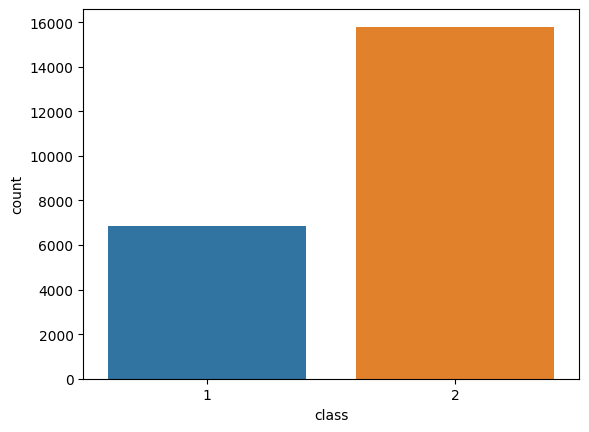

In [15]:
import seaborn as sns

sns.countplot(x='class', data=ryanair)
print("긍정 개수:", (ryanair["class"] == 2).sum())
print("부정 개수:", (ryanair["class"] == 1).sum()) 

In [16]:
data1=ryanair['class'].to_numpy()
data2=ryanair['contents'].to_numpy()

train data, test data 나누기

In [17]:
import numpy as np
np.array2string(data2)

'["Cheap flights, but you get what you pay for. Check in through the app has to be done 24hrs in advance (the app frequently crashes when trying to do this), or they ask you to pay to check in when you get there. I also purchased parking through the app, but it does not provide a location for the service. The temperature in flight was very hot and uncomfortable even with the vents open...during the winter. Good enough for a short flight, but I wouldn\'t travel too far with Ryanair."\n "Awful app tries to up sell you 4 ways, 4 times for each flight. Impossible to go back without losing data during check-in. Tries to get you to check in for your return flight but then won\'t let you without purchasing a seat selection. Then when you go back you have to start all over again for both flights. Absolute garbage."\n "From the user\'s point of view, the application is confusing. For example, I already ordered one cabin and one 20kg checked in baggage. But the app is offering to order it again,

In [18]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data2, data1, stratify=data1, test_size=0.2, random_state=42)

In [19]:
test_input

array(["It's fine nothing wow",
       'Had a flight to lanzarote today left on time arrived on time crew were nice \nhad bit of a laugh with them plane was spotless',
       'A very efficient app that does what it should be.', ...,
       'great app!', 'Great all round experience',
       'Easy and quick. Keep up the good work.'], dtype=object)

여기부터 분석 시작
tf-idf

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidfvector = TfidfVectorizer()
x_train_tfidf = tfidfvector.fit_transform(train_input)
tfidfv_test = tfidfvector.transform(test_input)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
params = {'alpha' : range(1, 1000)}
gs = GridSearchCV(MultinomialNB(), params, n_jobs = -1 )
gs.fit(x_train_tfidf, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt= gs.best_estimator_
print(dt.score(x_train_tfidf, train_target))
predicted = dt.predict(tfidfv_test)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 1}
0.9308348246029323
0.9506513579156547
정확도 :  0.9282402296312652


bow

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(train_input)
x_test_dtm= dtmvector.transform(test_input)

In [23]:
params = {'alpha' : range(1,1000)}
ks = GridSearchCV(MultinomialNB(), params, n_jobs = -1)
ks.fit(x_train_dtm, train_target)
print(ks.best_params_)
print(np.max(ks.cv_results_['mean_test_score']))
dt= ks.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 1}
0.9285164259005043
0.9461801722234489
정확도 :  0.9271362331640539


In [24]:
params = {'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]}
ks = GridSearchCV(MultinomialNB(), params, n_jobs = -1)
ks.fit(x_train_dtm, train_target)
print(ks.best_params_)
print(np.max(ks.cv_results_['mean_test_score']))
dt= ks.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 0.3}
0.9301172329835323
0.9540185471406492
정확도 :  0.9282402296312652


In [25]:
params = {'alpha' : [0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35]}
ks = GridSearchCV(MultinomialNB(), params, n_jobs = -1)
ks.fit(x_train_dtm, train_target)
print(ks.best_params_)
print(np.max(ks.cv_results_['mean_test_score']))
dt= ks.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 0.31}
0.93028284159518
0.9537425480238463
정확도 :  0.9282402296312652


베르누이

In [26]:
from sklearn.naive_bayes import BernoulliNB
params = {'alpha' : range(1, 1000)}
gs = GridSearchCV(BernoulliNB(), params, n_jobs = -1 )
gs.fit(x_train_dtm, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt= gs.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 1}
0.8388717776238271
0.8475380878781188
정확도 :  0.8377125193199382


In [27]:
from sklearn.naive_bayes import BernoulliNB
params = {'alpha' : range(1, 1000)}
gs = GridSearchCV(BernoulliNB(), params, n_jobs = -1 )
gs.fit(x_train_tfidf, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt= gs.best_estimator_
print(dt.score(x_train_tfidf, train_target))
predicted = dt.predict(tfidfv_test)
print("정확도 : ", accuracy_score(test_target, predicted))

{'alpha': 1}
0.8388717776238271
0.8475380878781188
정확도 :  0.8377125193199382


결정 트리

In [38]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, randint
params = {'min_impurity_decrease' : uniform(0.0001, 0.001), 'max_depth' : randint(20,50), 'min_samples_split' : randint(2,25), 'min_samples_leaf' : randint(1,25)}

In [39]:
from sklearn.model_selection import RandomizedSearchCV
ms = RandomizedSearchCV(DecisionTreeClassifier(), params, n_iter = 100, n_jobs=-1)
ms.fit(x_train_tfidf, train_target)
print(ms.best_params_)
print(np.max(ms.cv_results_['mean_test_score']))
dt= ms.best_estimator_
print(dt.score(x_train_tfidf, train_target))
predicted = dt.predict(tfidfv_test)
print("정확도 : ", accuracy_score(test_target, predicted))

{'max_depth': 49, 'min_impurity_decrease': 0.0003042993609316767, 'min_samples_leaf': 4, 'min_samples_split': 3}
0.880216671266906
0.9047251048796644
정확도 :  0.8778979907264297


In [30]:
bs = RandomizedSearchCV(DecisionTreeClassifier(), params, n_iter = 100, n_jobs=-1)
bs.fit(x_train_dtm, train_target)
print(bs.best_params_)
print(np.max(bs.cv_results_['mean_test_score']))
dt= bs.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'max_depth': 41, 'min_impurity_decrease': 0.00022999352169069868, 'min_samples_leaf': 3, 'min_samples_split': 16}
0.8781742412194837
0.9005299183042614
정확도 :  0.8816515787149481


로지스틱 회귀

In [31]:
from sklearn.linear_model import LogisticRegression
params = {'C': np.logspace(-4, 4, 50), 'penalty':['l2'], 'max_iter':[500]}
rs = GridSearchCV(LogisticRegression(random_state=0), params, cv=5,n_jobs=-1)
rs.fit(x_train_tfidf, train_target)
print(rs.best_params_)
print(np.max(rs.cv_results_['mean_test_score']))
dt= rs.best_estimator_
print(dt.score(x_train_tfidf, train_target))
predicted = dt.predict(tfidfv_test)
print("정확도 : ", accuracy_score(test_target, predicted))

{'C': 2.559547922699533, 'max_iter': 500, 'penalty': 'l2'}
0.9354164648349794
0.9674321042172666
정확도 :  0.9383969971296092


In [32]:
from sklearn.linear_model import LogisticRegression
params = {'C': np.logspace(-4, 4, 50), 'penalty':['l2'], 'max_iter':[500]}
ps = GridSearchCV(LogisticRegression(random_state=0), params, cv=5, n_jobs=-1)
ps.fit(x_train_dtm, train_target) # 수정
print(ps.best_params_)
print(np.max(ps.cv_results_['mean_test_score']))
dt= ps.best_estimator_
print(dt.score(x_train_dtm, train_target))
predicted = dt.predict(x_test_dtm)
print("정확도 : ", accuracy_score(test_target, predicted))

{'C': 1.7575106248547894, 'max_iter': 500, 'penalty': 'l2'}
0.9325461745202803
0.9756568778979907
정확도 :  0.9313314197394569


LightGBM

In [33]:
from lightgbm import LGBMClassifier
params = {'learning_rate' : [0.1,0.2,0.3,0.4,0.5], 'n_estimators' : [100,200,300,400,500], 'max_depth' : [3,4,5,6,7,8,9,10]}
gs = GridSearchCV(LGBMClassifier(), params, n_jobs = -1 )
gs.fit(x_train_tfidf, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt= gs.best_estimator_
print(dt.score(x_train_tfidf, train_target))
predicted = dt.predict(tfidfv_test)
print("정확도 : ", accuracy_score(test_target, predicted))

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 400}
0.9286818060234496
0.9863656436299404
정확도 :  0.9308898211525723
